In [1]:
import json
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, AutoImageProcessor, ViTModel
from PIL import Image
from IPython.display import display
os.environ["TOKENIZERS_PARALLELISM"] = "false"

2024-05-16 10:48:03.422025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 10:48:04.983313: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 10:48:09.164108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


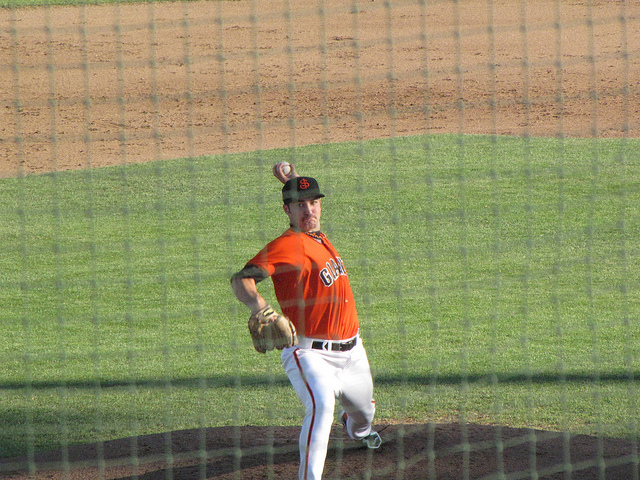

Question: What is this photo taken looking through?
Answer: net


In [2]:

# Define the relative paths to the dataset directories
dataset_dir = "Dataset/"
questions_dir = os.path.join(dataset_dir, "v2_Questions_Train_mscoco")
annotations_dir = os.path.join(dataset_dir, "v2_Annotations_Train_mscoco")
images_dir = os.path.join(dataset_dir, "train2014")
# F:\VR Final Project\Dataset\v2_Questions_Train_mscoco\v2_OpenEnded_mscoco_train2014_questions.json
# Load VQA annotations
with open(os.path.join(annotations_dir, "v2_mscoco_train2014_annotations.json"), "r") as f:
    train_annotations = json.load(f)
# v2_mscoco_train2014_annotations.json
with open(os.path.join(questions_dir, "v2_OpenEnded_mscoco_train2014_questions.json"), "r") as f:
    train_questions = json.load(f)
# v2_OpenEnded_mscoco_train2014_questions.json
question_id_to_question = {q["question_id"]: q["question"] for q in train_questions["questions"]}
# Define a function to load images
def load_image(image_id):
    image_path = os.path.join(images_dir, "COCO_train2014_" + str(image_id).zfill(12) + ".jpg")
    return Image.open(image_path)

def display_image(image_id):
    image_path = os.path.join(images_dir, "COCO_train2014_" + str(image_id).zfill(12) + ".jpg")
    image = Image.open(image_path)
    display(image)
# Example usage:
# Load the first question and answer pair
question_id = train_questions["questions"][0]["question_id"]
question_text = train_questions["questions"][0]["question"]
image_id = train_annotations["annotations"][0]["image_id"]
answer = train_annotations["annotations"][0]["multiple_choice_answer"]

display_image(image_id)

# Print question and answer
print("Question:", question_text)
print("Answer:", answer)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


In [3]:
                                                                                                            pip install --upgrade transformers

Requirement already up-to-date: transformers in /home/gpu1/.local/lib/python3.8/site-packages (4.40.2)
Note: you may need to restart the kernel to use updated packages.


In [4]:

# !pip uninstall torch torchvision torchaudio
!pip install --upgrade torch torchvision torchaudio


Requirement already up-to-date: torch in /home/gpu1/.local/lib/python3.8/site-packages (2.3.0)
Requirement already up-to-date: torchvision in /home/gpu1/.local/lib/python3.8/site-packages (0.18.0)
Requirement already up-to-date: torchaudio in /home/gpu1/.local/lib/python3.8/site-packages (2.3.0)


In [5]:
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [6]:
!pip install termcolor


In [7]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

In [8]:
# Tokenize questions using BERT tokenizer
question_texts = [question["question"] for question in train_questions["questions"]]
question_inputs = bert_tokenizer(question_texts, padding=True, truncation=True, return_tensors="pt")

In [9]:
# Process images in batches
def process_images_in_batches(image_ids, batch_size=64):
    image_batches = []
    for i in range(0, len(image_ids), batch_size):
        batch_ids = image_ids[i:i+batch_size]
        images = [load_image(image_id) for image_id in batch_ids]
        # Convert images to RGB if they are not
        images = [image.convert("RGB") for image in images]
        image_inputs = image_processor(images, return_tensors="pt")
        image_batches.append(image_inputs)
    return image_batches 

# image_ids = [annotation["image_id"] for annotation in train_annotations["annotations"]]
# image_batches = process_images_in_batches(image_ids)

# # Now image_batches contains the processed images in batches

In [10]:
# Select 25% of the dataset randomly
random.seed(42)  # For reproducibility
sample_size = int(len(train_annotations["annotations"]) * 0.05)
sampled_annotations = random.sample(train_annotations["annotations"], sample_size)

In [11]:
# Extract image IDs from the sampled annotations
image_ids = [annotation["image_id"] for annotation in sampled_annotations]
image_batches = process_images_in_batches(image_ids)

# Now image_batches contains the processed images in batches

In [12]:
# Custom dataset class for VQA
class VQADataset(Dataset):
    def __init__(self, annotations, question_id_to_question,image_processor, tokenizer):
        self.annotations = annotations
        self.question_id_to_question = question_id_to_question  # NEW/CHANGED
        self.image_processor = image_processor
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        question_id = annotation['question_id']  # NEW/CHANGED
        question = self.question_id_to_question[question_id]  # NEW/CHANGED
        answer = annotation['answer']  # This should be the index of the answer in your answer list
        image_id = annotation['image_id']
        image = load_image(image_id)
        image = image.convert("RGB")
        
        text_inputs = self.tokenizer(question, padding='max_length', truncation=True, return_tensors="pt")
        image_inputs = self.image_processor(images=image, return_tensors="pt")
        
        # Remove batch dimension from inputs
        text_inputs = {k: v.squeeze(0) for k, v in text_inputs.items()}
        image_inputs = {k: v.squeeze(0) for k, v in image_inputs.items()}
        
        return {
            'text_inputs': text_inputs,
            'image_inputs': image_inputs,
            'labels': torch.tensor(answer, dtype=torch.long)
        }


In [13]:

# Define the VQA model
class VQAModel(nn.Module):
    def __init__(self, text_model_name="bert-base-cased", image_model_name="google/vit-base-patch16-224", num_answers=1000):
        super(VQAModel, self).__init__()
        self.text_model = AutoModel.from_pretrained(text_model_name)
        self.image_model = ViTModel.from_pretrained(image_model_name)
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 512)
        self.image_fc = nn.Linear(self.image_model.config.hidden_size, 512)
        self.classifier = nn.Linear(1024, num_answers)

    def forward(self, text_inputs, image_inputs):
        text_outputs = self.text_model(**text_inputs).last_hidden_state[:, 0, :]  # CLS token
        image_outputs = self.image_model(**image_inputs).last_hidden_state[:, 0, :]  # CLS token
        text_features = self.text_fc(text_outputs)
        image_features = self.image_fc(image_outputs)
        combined_features = torch.cat((text_features, image_features), dim=1)
        logits = self.classifier(combined_features)
        return logits


In [14]:

answer_list = list(set(annotation['multiple_choice_answer'] for annotation in train_annotations["annotations"]))
answer_to_idx = {answer: idx for idx, answer in enumerate(answer_list)}


In [15]:
                
# Convert answers to indices in the annotations
for annotation in sampled_annotations:
    annotation['answer'] = answer_to_idx[annotation['multiple_choice_answer']]


In [16]:
num_answers = len(answer_list) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQAModel(num_answers=len(answer_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:

# Prepare dataset and dataloader
dataset = VQADataset(sampled_annotations,question_id_to_question, image_processor, bert_tokenizer)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)



In [18]:

# Training loop
def train(model, dataloader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            text_inputs = {k: v.to(device) for k, v in batch['text_inputs'].items()}
            image_inputs = {k: v.to(device) for k, v in batch['image_inputs'].items()}
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(text_inputs, image_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            torch.cuda.empty_cache()
        
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

# Start training
train(model, dataloader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Loss: 5.5924831639047845
Epoch 2/10, Loss: 5.117600685774969
Epoch 3/10, Loss: 5.047271778889985
Epoch 4/10, Loss: 5.007492413977706
Epoch 5/10, Loss: 4.968469131179859
Epoch 6/10, Loss: 4.942678858428168
Epoch 7/10, Loss: 4.901727401712725
Epoch 8/10, Loss: 4.868316264523887
Epoch 9/10, Loss: 4.823822729030299
Epoch 10/10, Loss: 4.778676638205416


In [45]:
# Set the model to evaluation mode
model.eval()

# Pick a random data point
random_annotation = random.choice(sampled_annotations)
image_id = random_annotation['image_id']
question_id = random_annotation['question_id']
question_text = question_id_to_question[question_id]


In [46]:

# Preprocess the question
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
inputs = tokenizer(question_text, return_tensors="pt", padding=True, truncation=True)

# Move inputs to appropriate device
inputs = {key: val.to(device) for key, val in inputs.items()}


In [47]:

# Load the image
image = load_image(image_id)
image = image.convert("RGB")

# Preprocess the image
image_inputs = image_processor(images=[image], return_tensors="pt")
image_inputs = {k: v.to(device) for k, v in image_inputs.items()}


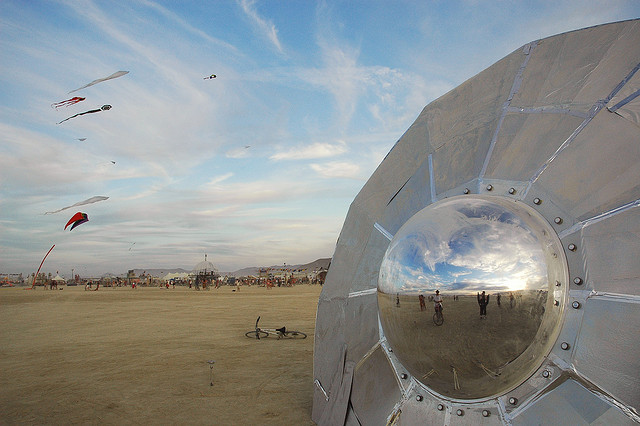

Question: Do you see a reflection?
Predicted Answer: no


In [48]:

# Pass the data through the model
with torch.no_grad():
    logits = model(inputs, image_inputs)

# Decode the prediction
predicted_answer_idx = torch.argmax(logits).item()
predicted_answer = answer_list[predicted_answer_idx]

# Display the question and predicted answer
display_image(image_id)

print("Question:", question_text)
print("Predicted Answer:", predicted_answer)